---
title: "人工智能 - 基于 Pytorch 的神经网络高效实现"
date: 2025-05-05T21:40:32+08:00
author: "Liu Zheng"
tags: ["笔记", "实验"]
categories: "实验笔记"
---

## 基于 Pytorch 的神经网络高效实现

做一个练习，寻找一个文本分类的大模型，找一个数据集，对其实现向量化和分类标注数据整理。然后自己构建神经网络层，实现简单的训练与推理。

找到了一个中文的数据集 [Qilin](https://huggingface.co/datasets/THUIR/Qilin) ，相关文献 [参考](https://arxiv.org/html/2503.00501v1) 。

准备利用 [BERT](https://huggingface.co/google-bert/bert-base-chinese?clone=true) 模型实现向量化。

In [1]:
import os
import torch
import pandas
import numpy
import matplotlib.pyplot
from transformers import AutoTokenizer, AutoModel
from IPython.display import display

matplotlib.pyplot.style.use("matplotlib.mplstyle")

if os.name == 'posix':  # Linux 或 macOS
    PREFIX = '/home/foliage/projects'
elif os.name == 'nt':  # Windows
    PREFIX = 'D:/Projects'
else:
    raise OSError("Unsupported operating system.")

# 输出路径 & 数据路径 & 模型路径加载
PATH_OUTPUT, PATH_DATASET, PATH_MODEL = "./202503122138.parquet", f"{PREFIX}/huggingface-qilin/dqa/train-00000-of-00001.parquet", f"{PREFIX}/huggingface-bert-base-chinese"

# 设置 GPU
DEVICE0, DEVICE1 = torch.device("cuda:0"), torch.device("cuda:1")

我们选择量化的 `query` 列和 `is_like_clk` 列进行相关实验来进行相关训练，`is_like_clk` 列是对该条回答内容的点赞、差评相关操作。接下来，我们使用 `google-bert` 模型实现文本向量化，形成一个(728)的向量。 

In [2]:
TOKENIZER, MODEL1 = AutoTokenizer.from_pretrained(PATH_MODEL), AutoModel.from_pretrained(PATH_MODEL).to(DEVICE1)

# 嵌入式向量
def embedding_text(texts):
    inputs = TOKENIZER(texts, return_tensors='pt', padding=True, truncation=True).to(DEVICE1)
    with torch.no_grad():
        outputs = MODEL1(**inputs)
    state = outputs.last_hidden_state
    return torch.mean(state, dim=1) # 平均池化操作

def embeddings_collect(batch):
    embeddings = []
    source = pandas.read_parquet(PATH_DATASET)
    display(source.info())
    for i in range(0, source["query"].size, batch):
        rows = source["query"][i:i + batch]
        batched_embeddings = embedding_text(rows.tolist()).tolist()
        embeddings.extend(batched_embeddings)
    return pandas.concat([source["query"], source[["is_like_clk", "is_onebox_trace_clk", "is_content_clk", "is_experience_clk"]], pandas.DataFrame({"embeddings": embeddings})], axis=1)

if not os.path.exists(PATH_OUTPUT):
    DATASET = embeddings_collect(32)
    DATASET.to_parquet(PATH_OUTPUT)
else:
    DATASET = pandas.read_parquet(PATH_OUTPUT)

display(DATASET.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6972 entries, 0 to 6971
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   query                           6972 non-null   object 
 1   query_from_type                 6972 non-null   float64
 2   dqa_output                      6972 non-null   object 
 3   is_like_clk                     6972 non-null   float64
 4   is_onebox_trace_clk             6972 non-null   float64
 5   is_content_clk                  6972 non-null   float64
 6   is_experience_clk               6972 non-null   float64
 7   recent_clicked_note_idxs        6972 non-null   object 
 8   ref_note_idx_list               6972 non-null   object 
 9   session_idx                     6972 non-null   int64  
 10  search_idx                      6972 non-null   int64  
 11  user_idx                        6972 non-null   int64  
 12  bm25_results                    69

None

,query,is_like_clk,is_onebox_trace_clk,is_content_clk,is_experience_clk,embeddings
0,珠海长隆长隆秀一定要海洋馆吗,-1.0,-1.0,-1.0,-1.0,"[0.13953915238380432, 0.3353746235370636, -0.2..."
1,高级经济师报考条件,0.0,0.0,1.0,0.0,"[0.21797794103622437, -0.10418368875980377, -0..."
2,仙山小农紫薇星君喜好,-1.0,-1.0,-1.0,-1.0,"[0.14661112427711487, -0.2250421941280365, -0...."
3,国考准考证怎么下载,0.0,0.0,1.0,0.0,"[0.4250069260597229, 0.09523293375968933, -0.2..."
4,国考准考证证件号码,-1.0,-1.0,-1.0,-1.0,"[0.09491205960512161, -0.0041047148406505585, ..."


我们得到了向量列 `embeddings` 现在我们需要进行逻辑回归训练，建立一个单层的神经网络。

In [3]:
# 定义逻辑回归模型
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(768, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
MODEL2 = LogisticRegression().to(DEVICE0)
DATASET_FILTERED = DATASET[DATASET["is_like_clk"] != 1] # 点赞率太低的数据过滤

# 定义损失函数和优化器
CRITERION, OPTIMIZER = torch.nn.BCELoss(), torch.optim.Adam(MODEL2.parameters(), lr=0.01)

X = torch.from_numpy(numpy.array(DATASET_FILTERED["embeddings"].tolist(), dtype=numpy.float32)).to(DEVICE0)
Y = (torch.from_numpy(numpy.array(DATASET_FILTERED["is_like_clk"].tolist(), dtype=numpy.float32)) + 1).unsqueeze(1).to(DEVICE0)

# 手动训练
HISTORY = []
EPOCHS = 200
for epoch in range(EPOCHS):
    pred = MODEL2(X) # 前向传播
    loss = CRITERION(pred, Y) # 损失计算
    OPTIMIZER.zero_grad() # 清除梯度
    loss.backward() # 计算梯度
    OPTIMIZER.step() # 更新参数
    if (epoch + 1) % 10 == 0:
        dict = MODEL2.state_dict()
        HISTORY.append([loss.item()])

print(pandas.DataFrame(HISTORY, columns=["LOSS"]).to_string(formatters={"LOSS": '{:.4e}'.format}))

         LOSS
0  5.1649e-01
1  4.9098e-01
2  4.7522e-01
3  4.6480e-01
4  4.5764e-01
5  4.5206e-01
6  4.4755e-01
7  4.4380e-01
8  4.4061e-01
9  4.3785e-01
10 4.3544e-01
11 4.3331e-01
12 4.3142e-01
13 4.2972e-01
14 4.2819e-01
15 4.2680e-01
16 4.2554e-01
17 4.2438e-01
18 4.2332e-01
19 4.2234e-01


我们通过图标来展示代价函数计算的梯度

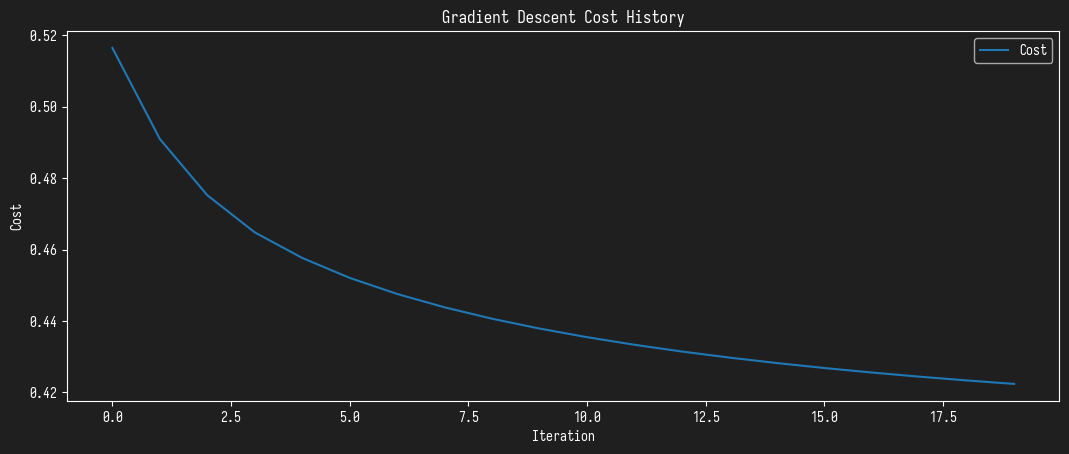

In [4]:
def draw_gradient_descent_cost_history(history, figure):
    axes1 = figure.add_subplot()
    axes1.plot(history, label="Cost")
    axes1.set_title("Gradient Descent Cost History")
    axes1.set_ylabel("Cost")
    axes1.set_xlabel("Iteration")
    axes1.legend()

draw_gradient_descent_cost_history(HISTORY, matplotlib.pyplot.figure())

matplotlib.pyplot.show()

接下来进行推理，需要注意的是，这是一个简化逻辑回归，单层神经网络，它默认特征与分类呈现线性关系。

但是在现实生活中，特征和预测值之间呈现的是非线性关系，所以一定程度上使用的应该是多层神经网络，甚至于个人猜测，特征工程也缺少相关的信息。

In [5]:
features = ["北京怎么了突然刮大风"]
SAMPLE = embedding_text(features).to(DEVICE0)

with torch.no_grad():
    label = MODEL2(SAMPLE)

print(f"Logistic for label: {label}")

Logistic for label: tensor([[0.7504]], device='cuda:0')
